## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Library

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)

import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

import time

import random
random.seed(777)

## GPU Setting

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

print(f'Using PyTorch version: {torch.__version__} / Device: {device}')

Using PyTorch version: 1.8.1+cu101 / Device: cuda


## Hyperparameters

In [4]:
TRAINPATH = 'drive/MyDrive/Capstone-Design/dataset/AIHub/train' 
SAVEPATH = 'drive/MyDrive/Capstone-Design/model/AIHub_Aug/GoogLeNet'

LOADEPOCH = 0
ACC = 0

LR = 0.01
MOMENTUM = 0.9
WEIGHTDECAY = 5e-4

EPOCHS = 100
STEPSIZE = 30
GAMMA = 0.1

BATCHSIZE = 32

PRINTFREQ = 10

## Data Load

In [5]:
transfrom_train = transforms.Compose([
                            # transforms.RandomCrop(32, padding=4),
                            # transforms.RandomResizedCrop(224),
                            transforms.Resize(224),
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomRotation(10),
                            transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                            transforms.ToTensor(),
                            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                            ])

# transform_test = transforms.Compose([
#     transforms.Resize(224),
#     transforms.ToTensor(), 
#     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
# ])

train_dataset = torchvision.datasets.ImageFolder(root=TRAINPATH, transform=transfrom_train)

train_len = int((8/10) * len(train_dataset))
valid_len = len(train_dataset) - train_len

torch.manual_seed(777)
train_data, valid_data = torch.utils.data.dataset.random_split(train_dataset, [train_len, valid_len])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCHSIZE, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=BATCHSIZE, shuffle=False, num_workers=2)

# test_data = torchvision.datasets.ImageFolder(root=TESTPATH, transform=transform_test)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCHSIZE, shuffle=False, num_workers=2)


classes = ('궤양병', '잎곰팡이병', '점무늬병', '황화잎말림바이러스', '아메리카잎굴파리', '청벌레', '정상')

In [6]:
print("train data:", len(train_data))
print("valid data:", len(valid_data))
# print("test data:", len(test_data))

train data: 11964
valid data: 2991


## Define Model

In [7]:
class ConvBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

In [8]:
class InceptionModule(nn.Module):
    
    def __init__(self, in_channels, f_1x1, f_3x3_r, f_3x3, f_5x5_r, f_5x5, f_pp):
        super(InceptionModule, self).__init__()
        
        self.branch1 = nn.Sequential(
            ConvBlock(in_channels, f_1x1, kernel_size=1, stride=1, padding=0)
        )
        
        self.branch2 = nn.Sequential(
            ConvBlock(in_channels, f_3x3_r, kernel_size=1, stride=1, padding=0),
            ConvBlock(f_3x3_r, f_3x3, kernel_size=3, stride=1, padding=1)
        )
        
        self.branch3 = nn.Sequential(
            ConvBlock(in_channels, f_5x5_r, kernel_size=1, stride=1, padding=0),
            ConvBlock(f_5x5_r, f_5x5, kernel_size=5, stride=1, padding=2)
        )
        
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1, ceil_mode=True),
            ConvBlock(in_channels, f_pp, kernel_size=1, stride=1, padding=0)
        )
        
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        
        return torch.cat([branch1, branch2, branch3, branch4], 1)

In [9]:
class InceptionAux(nn.Module):
    
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        
        self.pool = nn.AdaptiveAvgPool2d((4,4))
        self.conv = nn.Conv2d(in_channels, 128, kernel_size=1, stride=1, padding=0)
        self.act = nn.ReLU()
        self.fc1 = nn.Linear(2048, 1024)
        self.dropout = nn.Dropout(0.7)
        self.fc2 = nn.Linear(1024, num_classes)
    
    def forward(self, x):
        x = self.pool(x)
        
        x = self.conv(x)
        x = self.act(x)
    
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        
        return x

In [10]:
class GoogLeNet(nn.Module):
    
    def __init__(self, num_classes = 10):
        super(GoogLeNet, self).__init__()
      
        self.conv1 = ConvBlock(3, 64, kernel_size=7, stride=2, padding=3)
        self.pool1 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)
        self.conv2 = ConvBlock(64, 64, kernel_size=1, stride=1, padding=0)
        self.conv3 = ConvBlock(64, 192, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)
        self.inception3A = InceptionModule(in_channels=192,
                                           f_1x1=64,
                                           f_3x3_r=96,
                                           f_3x3=128,
                                           f_5x5_r=16,
                                           f_5x5=32,
                                           f_pp=32)
        self.inception3B = InceptionModule(in_channels=256,
                                           f_1x1=128,
                                           f_3x3_r=128,
                                           f_3x3=192,
                                           f_5x5_r=32,
                                           f_5x5=96,
                                           f_pp=64)
        self.pool4 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)
        self.inception4A = InceptionModule(in_channels=480,
                                           f_1x1=192,
                                           f_3x3_r=96,
                                           f_3x3=208,
                                           f_5x5_r=16,
                                           f_5x5=48,
                                           f_pp=64)
        self.inception4B = InceptionModule(in_channels=512,
                                           f_1x1=160,
                                           f_3x3_r=112,
                                           f_3x3=224,
                                           f_5x5_r=24,
                                           f_5x5=64,
                                           f_pp=64)
        self.inception4C = InceptionModule(in_channels=512,
                                           f_1x1=128,
                                           f_3x3_r=128,
                                           f_3x3=256,
                                           f_5x5_r=24,
                                           f_5x5=64,
                                           f_pp=64)
        self.inception4D = InceptionModule(in_channels=512,
                                           f_1x1=112,
                                           f_3x3_r=144,
                                           f_3x3=288,
                                           f_5x5_r=32,
                                           f_5x5=64,
                                           f_pp=64)
        self.inception4E = InceptionModule(in_channels=528,
                                           f_1x1=256,
                                           f_3x3_r=160,
                                           f_3x3=320,
                                           f_5x5_r=32,
                                           f_5x5=128,
                                           f_pp=128)
        self.pool5 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)
        self.inception5A = InceptionModule(in_channels=832,
                                           f_1x1=256,
                                           f_3x3_r=160,
                                           f_3x3=320,
                                           f_5x5_r=32,
                                           f_5x5=128,
                                           f_pp=128)
        self.inception5B = InceptionModule(in_channels=832,
                                           f_1x1=384,
                                           f_3x3_r=192,
                                           f_3x3=384,
                                           f_5x5_r=48,
                                           f_5x5=128,
                                           f_pp=128)
        self.pool6 = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)
        
        self.aux4A = InceptionAux(512, num_classes) 
        self.aux4D = InceptionAux(528, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.inception3A(x)
        x = self.inception3B(x)
        x = self.pool4(x)
        x = self.inception4A(x)
  
        aux1 = self.aux4A(x)
        
        x = self.inception4B(x)
        x = self.inception4C(x)
        x = self.inception4D(x)
  
        aux2 = self.aux4D(x)
        
        x = self.inception4E(x)
        x = self.pool5(x)
        x = self.inception5A(x)
        x = self.inception5B(x)
        x = self.pool6(x)
        x = torch.flatten(x,1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x, aux1, aux2

In [11]:
model = GoogLeNet(num_classes=7)

## Load Model

In [12]:
if LOADEPOCH != 0:
  model.load_state_dict(torch.load(f'{SAVEPATH}/model_epoch_{LOADEPOCH}_acc_{ACC}.pth'))
  # model.eval()
  print(f'Load Model: model_epoch_{LOADEPOCH}_acc_{ACC}')
else:
  print('New Model')

New Model


## Train Model

In [13]:
model = model.to(device)

In [14]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHTDECAY)
lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size=STEPSIZE, gamma=GAMMA)

In [15]:
def acc_check(net, test_set, epoch, save=1):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_set:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs, aux1, aux2 = net(images)

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    acc = (100 * correct / total)
    print(f'Accuracy of the network on the {len(valid_data)} test images: {acc:.2f} %')
    if save:
        torch.save(net.state_dict(), SAVEPATH + "/model_epoch_{}_acc_{}.pth".format(epoch, int(acc)))
    return acc

In [16]:
import time

In [17]:
start_time = time.time()
print('hi')
end_time = time.time()
print(f'{end_time - start_time:.4f}')

hi
0.0008


In [18]:
print(len(train_loader))
print('Start training')

valid_accuracy = []
valid_loss = []

for epoch in range(EPOCHS):  # loop over the dataset multiple times
    print(f"======================[Epoch {epoch+1:2d}]======================")
    start_time = time.time()
    running_loss = 0.0
    lr_sche.step()

    if epoch < LOADEPOCH:
      continue

    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, aux1, aux2 = model(inputs)
        # print(outputs)
        loss_outputs = criterion(outputs, labels)
        loss_aux1 = criterion(outputs, labels)
        loss_aux2 = criterion(outputs, labels)
        loss = loss_outputs + 0.3 * (loss_aux1 + loss_aux2)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i + 1) % PRINTFREQ == 0:
            # value_tracker(loss_plt, torch.Tensor([running_loss/30]), torch.Tensor([i + epoch*len(trainloader) ]))
            print('[%3d, %4d] loss: %.3f' % (epoch+1, i+1, running_loss / PRINTFREQ))
            running_loss = 0.0
    
    #Check Accuracy
    end_time = time.time()
    print(f'{end_time - start_time:.4f}')
    acc = acc_check(model, valid_loader, epoch+1, save=1)
    valid_accuracy.append(acc)
    valid_loss.append(loss.item())

    # test_acc = acc_check(model, test_loader, epoch+1, save=0)
    # value_tracker(acc_plt, torch.Tensor([acc]), torch.Tensor([epoch]))
    

print('Finished Training')

374
Start training
======================[Epoch  1]======================


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[  1,   10] loss: 2.358
[  1,   20] loss: 1.809
[  1,   30] loss: 1.991
[  1,   40] loss: 1.861
[  1,   50] loss: 2.271
[  1,   60] loss: 1.952
[  1,   70] loss: 2.000
[  1,   80] loss: 1.452
[  1,   90] loss: 1.631
[  1,  100] loss: 1.672
[  1,  110] loss: 1.915
[  1,  120] loss: 2.058
[  1,  130] loss: 1.647
[  1,  140] loss: 1.782
[  1,  150] loss: 1.672
[  1,  160] loss: 1.474
[  1,  170] loss: 1.755
[  1,  180] loss: 1.381
[  1,  190] loss: 1.608
[  1,  200] loss: 1.823
[  1,  210] loss: 2.133
[  1,  220] loss: 1.902
[  1,  230] loss: 2.454
[  1,  240] loss: 2.203
[  1,  250] loss: 1.912
[  1,  260] loss: 1.666
[  1,  270] loss: 1.817
[  1,  280] loss: 1.834
[  1,  290] loss: 1.539
[  1,  300] loss: 1.421
[  1,  310] loss: 1.474
[  1,  320] loss: 1.702
[  1,  330] loss: 1.471
[  1,  340] loss: 1.231
[  1,  350] loss: 1.351
[  1,  360] loss: 1.443
[  1,  370] loss: 1.695
73.5937
Accuracy of the network on the 2991 test images: 69.98 %
======================[Epoch  2]===============

## Test Model

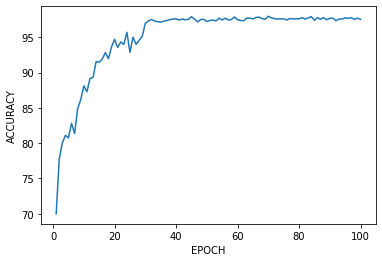

In [19]:
import matplotlib.pyplot as plt

epochs = [i for i in range(1, 101)]

plt.plot(epochs, valid_accuracy)
plt.xlabel('EPOCH')
plt.ylabel('ACCURACY')
plt.show()

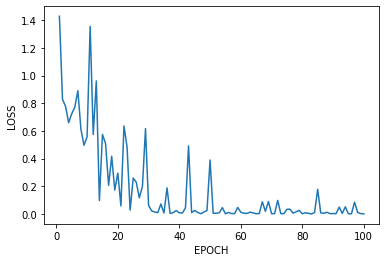

In [20]:
plt.plot(epochs, valid_loss)
plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.show()

In [21]:
class_correct = list(0. for i in range(7))
class_total = list(0. for i in range(7))
with torch.no_grad():
    for data in valid_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs, aux1, aux2 = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(7):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of   궤양병 : 90 %
Accuracy of 잎곰팡이병 : 93 %
Accuracy of  점무늬병 : 97 %
Accuracy of 황화잎말림바이러스 : 92 %
Accuracy of 아메리카잎굴파리 : 97 %
Accuracy of   청벌레 : 68 %
Accuracy of    정상 : 99 %


In [22]:
correct = 0
total = 0

with torch.no_grad():
    for data in valid_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs, aux1, aux2 = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(valid_data)} test images: {(100 * correct)/total:.2f} %')

Accuracy of the network on the 2991 test images: 97.76 %


In [23]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

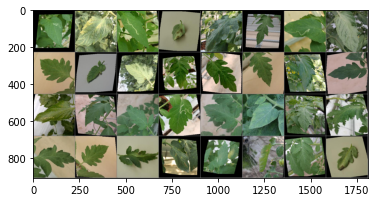

In [24]:
dataiter = iter(valid_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))

In [25]:
print('GroundTruth: \n', ' '.join('%5s \n' % classes[labels[j]] for j in range(10)))

GroundTruth: 
 아메리카잎굴파리 
    정상 
 아메리카잎굴파리 
 잎곰팡이병 
  점무늬병 
    정상 
 아메리카잎굴파리 
    정상 
    정상 
  점무늬병 



In [26]:
outputs, aux1, aux2 = model(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: \n', ' '.join('%5s \n' % classes[predicted[j]] for j in range(10)))

Predicted: 
 아메리카잎굴파리 
    정상 
 아메리카잎굴파리 
 잎곰팡이병 
  점무늬병 
    정상 
 아메리카잎굴파리 
    정상 
    정상 
  점무늬병 

